In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
from scipy import signal
import h5py
import glob
import itertools
from ast import literal_eval
from scipy.interpolate import interp1d

def roc_params_build(rocx, rocy, ftype):
    output = {}
    bound_sup = 2
    bound_inf = 0
    basis = np.linspace(bound_inf, bound_sup, 15)
    for i in range(0, rocx.shape[1]):
        xt = interp1d(rocx[:,i], basis, fill_value = 'extrapolate')
        yt = interp1d(rocy[:,i],basis, fill_value = 'extrapolate')
        tx = interp1d(basis,rocx[:,i], fill_value = 'extrapolate')
        ty = interp1d(basis,rocy[:,i], fill_value = 'extrapolate')
        xy = interp1d(rocx[:,i], rocy[:,i], fill_value = 'extrapolate')
        yx = interp1d(rocy[:,i], rocx[:,i], fill_value = 'extrapolate')
        output[ftype[i]] = [[xt,tx],[yt,ty],[xy,yx]]
   
    return output

def bug_array_fix(df, column):
    df_out = df[column]
    df_out = df_out.str.replace('\n',',').str.replace('  ',',').str.replace('[','').str.replace(']','').str.replace(' ',',').str.split(',')
    return df_out.apply(lambda x: (np.array(x)[np.array(x)!='']).astype(np.float))

def get_roc_params(dfx,dfy, sg_eff = 0.99):
    roc_x = np.array(np.matrix(dfx.tolist()))
    roc_y = np.array(np.matrix(dfy.tolist()))
    auc = abs(np.diff(np.array(roc_x))*np.array(roc_y)[:,:-1]).sum(axis = 1)
    bg_fix = []
    for i in range(0,roc_x.shape[0]):
        x = np.array(roc_x[i,:])
        y = np.array(roc_y[i,:])
        f = interp1d(x,y,fill_value = 'extrapolate')
        bg_fix.append(f(sg_eff))
    return auc, bg_fix, roc_y[:,index]


def roc_params(dfx, dfy, thresholds):
  bound_sup = 2
  bound_inf = 0
  basis = np.linspace(bound_inf, bound_sup, 15)
  roc_x = np.array(np.matrix(dfx.tolist()))
  roc_y = np.array(np.matrix(dfy.tolist()))
  auc = abs(np.diff(np.array(roc_x))*np.array(roc_y)[:,:-1]).sum(axis = 1)
  signal_eff = np.zeros((roc_x.shape[0], len(thresholds)))
  bg_eff = np.zeros((roc_x.shape[0], len(thresholds)))
  roc_point = np.zeros((roc_x.shape[0], len(thresholds)))
  for (n, t) in list(enumerate(thresholds)):
    for i in range(0,roc_x.shape[0]):
      x = np.array(roc_x[i,:])
      y = np.array(roc_y[i,:])
      fx = interp1d(basis, x, fill_value = 'extrapolate')
      fy = interp1d(basis, y, fill_value = 'extrapolate')
      fxy = interp1d(x, y, fill_value = 'extrapolate')
      signal_eff[i, n] = fx(t)
      bg_eff[i, n] = fy(t)
      roc_point[i, n] = fxy(t)
   
  return auc, signal_eff, bg_eff, roc_point 



def scatter(df_filt, key_analysis, labels, title):
    import matplotlib
    #key_analysis = ['Intensity mean','delta_bg_eff_1_cumulative']
    fig = plt.figure(figsize=(12,8))
    x           = df_filt[key_analysis[0]]
    y           = df_filt[key_analysis[1]]
    label_name  = df_filt.ftype

    ## enconding labels
    from sklearn import preprocessing
    le          = preprocessing.LabelEncoder()
    le.fit(label_name)
    label       = le.transform(label_name)

    ## selecionando cores para plot de forma randomica
    np.random.seed(10)
    colors = np.random.rand(len(np.unique(label)),3)

    ## scatter plots pelas cores de cada classe (w)
    plt.scatter(x, 100*y, c=label, alpha=0.3,cmap=matplotlib.colors.ListedColormap(colors))

    ## ajustes do plot e barra de exibicao
    plt.xlabel(labels[0],fontsize = 14)
    plt.ylabel(labels[1],fontsize = 12)
    plt.title(title)
    plt.grid()
    cb = plt.colorbar()
    loc = np.arange(0,max(label),max(label)/float(len(colors)))
    cb.set_ticks(loc+0.25)
    ## criando labels na colorbar
    ticklabels = []
    for i in np.unique(label_name):
        ticklabels.append(i)

    cb.set_ticklabels(ticklabels)

In [3]:
df = pd.read_csv('../data/result.csv')
df.head(10)

,SNR,w_size,Energy,Area,filter,window,ROCx,ROCy,Energy Estimated
0,-98.861418,1.0,2539.0,561.0,mean,1.0,[0.81639929 0.78609626 0.75044563 0.72727273 0...,[0.56160377 0.61983386 0.67364852 0.72375881 0...,[2491.24288843 2484.59591205 2469.1854857 245...
1,-100.453531,1.0,1683.0,677.0,mean,1.0,[0.74002954 0.70014771 0.6661743 0.62481536 0...,[0.5605564 0.61926744 0.6735764 0.72422141 0...,[2005.01534042 1999.00352824 1984.79274869 196...
2,-88.543275,1.0,4110.0,925.0,mean,1.0,[0.77513514 0.73837838 0.68972973 0.65837838 0...,[0.56213369 0.62021905 0.67499301 0.72511571 0...,[3929.80273018 3921.78296955 3894.00813124 385...
3,-103.678260,1.0,2123.0,703.0,mean,1.0,[0.77240398 0.7254623 0.69416785 0.65860597 0...,[0.56213448 0.61985687 0.67447722 0.72445408 0...,[2159.14109492 2152.16019257 2137.75250343 211...
4,-81.402118,1.0,4106.0,942.0,mean,1.0,[0.8163482 0.78768577 0.75265393 0.71974522 0...,[0.56351406 0.62003737 0.67352088 0.72435893 0...,[4176.15978631 4170.98152332 4144.2290967 411...
5,-88.518974,1.0,2437.0,772.0,mean,1.0,[0.74093264 0.70207254 0.65803109 0.62046632 0...,[0.56124221 0.61978712 0.67444103 0.72466829 0...,[2551.40145868 2545.13237688 2526.71781213 249...
6,-90.161462,1.0,2525.0,820.0,mean,1.0,[0.73658537 0.69146341 0.65609756 0.60243902 0...,[0.56279561 0.62052471 0.67470649 0.72549785 0...,[2647.47393917 2639.52821566 2617.56955608 256...
7,-54.894010,1.0,4120.0,831.0,mean,1.0,[0.83634176 0.80746089 0.78219013 0.75451264 0...,[0.56121969 0.6186489 0.67435221 0.72430763 0...,[4206.024026 4199.83304581 4185.75244176 415...
8,-87.593892,1.0,4120.0,802.0,mean,1.0,[0.81670823 0.78678304 0.75062344 0.72069825 0...,[0.56106558 0.61839658 0.67276595 0.7239441 0...,[4230.83836896 4222.20237002 4203.21775496 418...
9,-100.510535,1.0,2615.0,770.0,mean,1.0,[0.79480519 0.74805195 0.71298701 0.67662338 0...,[0.56230536 0.62037157 0.67495619 0.72506447 0...,[2676.01577274 2666.85378416 2648.11919232 261...


In [4]:
df['ROCx'] = bug_array_fix(df,'ROCx')
df['ROCy'] = bug_array_fix(df,'ROCy')

In [5]:
t_values    = [.5,1.,1.5]
new_sg_columns = ['sg_eff_'+str(i) for i in t_values]
new_bg_columns = ['bg_eff_'+str(i) for i in t_values] 
auc,sg,bg,_ = roc_params(df['ROCx'], df['ROCy'],[1,1.5,2])
efficiency_df = pd.DataFrame(np.append(sg,bg,axis = 1), columns=new_sg_columns+new_bg_columns)
df = pd.concat([df,efficiency_df],axis = 1)

In [6]:
index = list(range(0,100))
n_size = df.shape[0]//100
indexes = n_size*index
df['image_num'] = indexes
df.head(3)

,SNR,w_size,Energy,Area,filter,window,ROCx,ROCy,Energy Estimated,sg_eff_0.5,sg_eff_1.0,sg_eff_1.5,bg_eff_0.5,bg_eff_1.0,bg_eff_1.5,image_num
0,-98.861418,1.0,2539.0,561.0,mean,1.0,"[0.81639929, 0.78609626, 0.75044563, 0.7272727...","[0.56160377, 0.61983386, 0.67364852, 0.7237588...",[2491.24288843 2484.59591205 2469.1854857 245...,0.573975,0.462567,0.352941,0.875321,0.945365,0.978642,0
1,-100.453531,1.0,1683.0,677.0,mean,1.0,"[0.74002954, 0.70014771, 0.6661743, 0.62481536...","[0.5605564, 0.61926744, 0.6735764, 0.72422141,...",[2005.01534042 1999.00352824 1984.79274869 196...,0.422452,0.284343,0.186115,0.875873,0.945812,0.979420,1
2,-88.543275,1.0,4110.0,925.0,mean,1.0,"[0.77513514, 0.73837838, 0.68972973, 0.6583783...","[0.56213369, 0.62021905, 0.67499301, 0.7251157...",[3929.80273018 3921.78296955 3894.00813124 385...,0.495135,0.375135,0.272432,0.876173,0.946298,0.979381,2


In [7]:
deltas = ['delta_' + st for st in list(efficiency_df.columns) + ['SNR']]
cumulatives = [i + '_cumulative' for i in deltas]
columns = list(df.columns) + deltas + cumulatives
dfObj = pd.DataFrame(columns=columns)
dfObj

,SNR,w_size,Energy,Area,filter,window,ROCx,ROCy,Energy Estimated,sg_eff_0.5,...,delta_bg_eff_1.0,delta_bg_eff_1.5,delta_SNR,delta_sg_eff_0.5_cumulative,delta_sg_eff_1.0_cumulative,delta_sg_eff_1.5_cumulative,delta_bg_eff_0.5_cumulative,delta_bg_eff_1.0_cumulative,delta_bg_eff_1.5_cumulative,delta_SNR_cumulative


In [8]:
values = list(df.groupby(by=['image_num','filter']))
data = pd.DataFrame([],columns = values[0][1].columns)

In [9]:
#data = dict((k,[]) for k in deltas+cumulatives)
#data = pd.DataFrame([],columns = aux.columns)
for i in range(0,len(values)):
    aux = values[i][1]
    for key1,key2 in zip(deltas, cumulatives):
        diff = np.pad(np.diff(aux[key1.split('delta_')[1]]),(1,0),'constant')
        diff_cum = diff.cumsum()
        #data[key1] = np.append(data[key1],diff)
        #data[key2] = np.append(data[key2],diff_cum)
        aux[key1] = diff
        aux[key2] = diff_cum
        #data.columns = aux.columns
    data = data.append(aux)
    #aux = aux[aux.columns]    
    #dfObj = pd.concat([dfObj,aux],axis = 0)    
#dfObj.head(3)        

/home/renatel/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [10]:
df = data
df['Intensity mean'] = df['Energy']/df['Area']

In [11]:
## filtrando dados para visualizacao
filtro = ['mean','median']   ## somente filtros listados
window = [1,3,5,7]              ## somente nestas janelas

df_filt    = df[df.window.isin(window)]
pattern    = '|'.join(filtro)
df_filt    = df_filt[df_filt['filter'].str.contains(pattern)]
new_column = df_filt['filter']  + ', window = ' + df_filt['window'].astype('str') 
df_filt.drop(['filter','window'],axis = 1,inplace = True)
df_filt['ftype']  = new_column
df_filt.head(3)

,Area,Energy,Energy Estimated,ROCx,ROCy,SNR,bg_eff_0.5,bg_eff_1.0,bg_eff_1.5,delta_SNR,...,delta_sg_eff_1.0_cumulative,delta_sg_eff_1.5,delta_sg_eff_1.5_cumulative,image_num,sg_eff_0.5,sg_eff_1.0,sg_eff_1.5,w_size,Intensity mean,ftype
0,561.0,2539.0,[2491.24288843 2484.59591205 2469.1854857 245...,"[0.81639929, 0.78609626, 0.75044563, 0.7272727...","[0.56160377, 0.61983386, 0.67364852, 0.7237588...",-98.861418,0.875321,0.945365,0.978642,0.000000,...,0.000000,0.000000,0.000000,0,0.573975,0.462567,0.352941,1.0,4.525847,"mean, window = 1.0"
300,561.0,2539.0,[2197.1802534 2206.97101611 2179.67170946 216...,"[0.90552585, 0.8627451, 0.80392157, 0.73796791...","[0.67361793, 0.78803286, 0.86479626, 0.9141763...",-87.036618,0.984984,0.995791,0.998746,11.824799,...,-0.112299,-0.115865,-0.115865,0,0.534759,0.350267,0.237077,3.0,4.525847,"mean, window = 3.0"
600,561.0,2539.0,[2152.55396157 2153.2946855 2185.0520358 207...,"[0.942959, 0.8912656, 0.79857398, 0.7486631, 0...","[0.77270312, 0.89284472, 0.95071163, 0.9771086...",-83.488092,0.998700,0.999811,0.999981,3.548527,...,-0.186275,-0.069519,-0.185383,0,0.422460,0.276292,0.167558,5.0,4.525847,"mean, window = 5.0"


## Rejeição de background 1.5 sigma

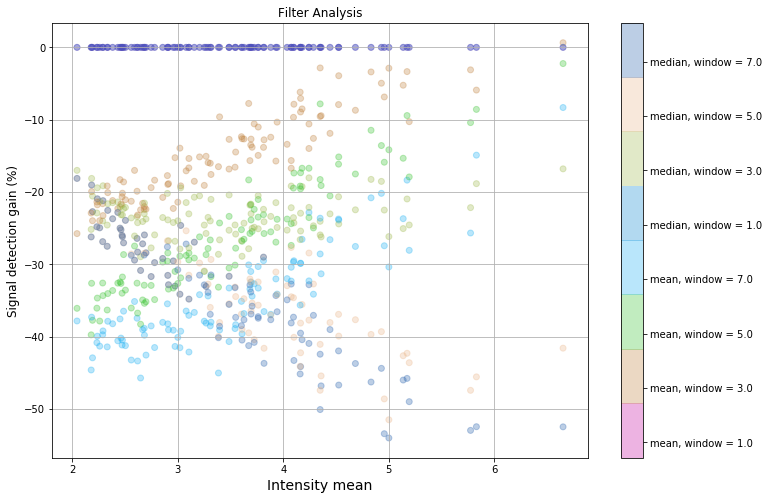

In [12]:
scatter(df_filt, 
        ['Intensity mean','delta_sg_eff_0.5_cumulative'],
        ['Intensity mean','Signal detection gain (%)'], 
        'Filter Analysis')

## Construindo a ROC média e std

In [13]:
#df_filt
filters = df_filt['ftype'].unique()
mean_sg = np.zeros((df_filt['ROCx'].iloc[0].shape[0],
                    filters.shape[0]))
std_sg = np.zeros_like(mean_sg)
mean_bg = np.zeros_like(mean_sg)
std_bg = np.zeros_like(mean_sg)
for i,f in list(enumerate(filters)):
    aux = df_filt[df_filt['ftype'] == f]
    roc_x = np.array(aux['ROCx'].tolist())
    roc_y = np.array(aux['ROCy'].tolist())
    if(len(roc_x.shape) > 2):
        roc_x = roc_x[:,:,0]
    mean_sg[:,i] = roc_x.mean(axis=0)
    std_sg[:,i] = roc_x.std(axis = 0)
    mean_bg[:,i] = roc_y.mean(axis=0)
    std_bg[:,i] = roc_y.std(axis=0)

## Plot das ROC's para sinal fixo -> melhoria no numero de pixels de background (tempo de processamento)

Text(0, 0.5, 'Background rejection efficiency')

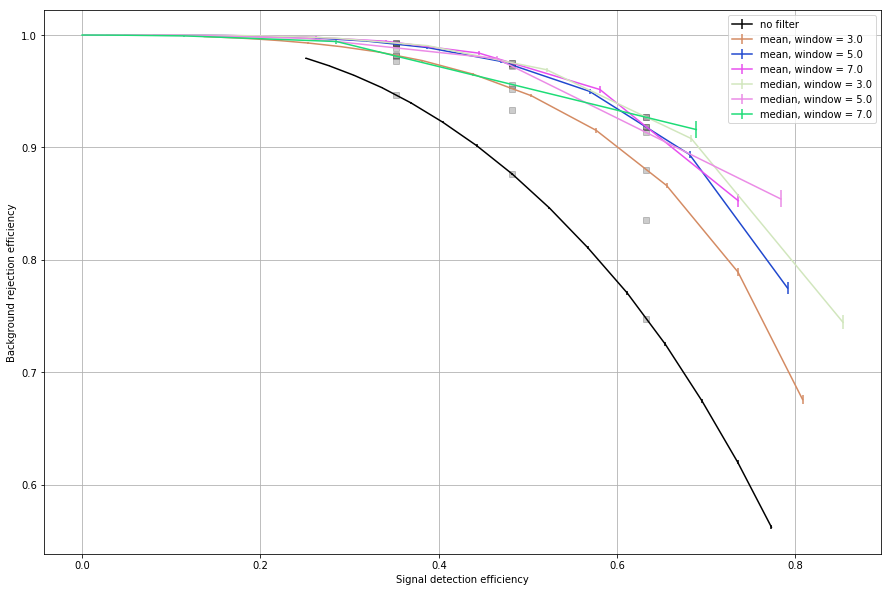

In [15]:
np.random.seed(5)
thr_points = [0.5,1,1.5]
new_thr_values = []
objects = roc_params_build(mean_sg,mean_bg,filters)
base_signal_values = objects[filters[0]][0][1](thr_points)
base_background_values = []
fig,ax = plt.subplots(1,1, figsize=(15,10))
flag = 0
for i,f in list(enumerate(filters)):
    base_background_values.append(objects[f][2][0](base_signal_values))
    if (sum(df_filt[df_filt['w_size'] == 1.0]['ftype'] == filters[i]) != 0):
        color = 'black'
        label = 'no filter'
        flag+=1
        if flag<=1:
            ax.errorbar(mean_sg[:,i],
                        mean_bg[:,i],
                        2*std_bg[:,i],
                        linestyle = '-',
                        label = label,
                        color = color) 
            
    else:
        color = '#%06X' % np.random.randint(0, 0xFFFFFF)
        label = f
        ax.errorbar(mean_sg[:,i],
                    mean_bg[:,i],
                    2*std_bg[:,i],
                    linestyle = '-',
                    label = label,
                    color = color) 
base_background_values = np.array(base_background_values).ravel()   
base_signal_values = np.tile(base_signal_values,len(filters))
ax.plot(base_signal_values,base_background_values,'sk',alpha = 0.2)
#plt.plot(impx_points,impy_points,'ko',alpha = 0.4)   
#plt.plot(impx_points,impy_points,'ko',alpha = 0.4)

#thr = df_filt[df_filt['ftype']=='mean, window = 1.0']['sg_eff_1.5'].mean()
#plt.plot(thr*np.ones((70,)),mean_bg[:,0],'--b', label = 'threshold = 1.5 sigma')
#thr = df_filt[df_filt['ftype']=='mean, window = 1.0']['sg_eff_0.5'].mean()
#plt.plot(thr*np.ones((70,)),mean_bg[:,0],'--r', label = 'threshold = 0.5 sigma')
#thr = df_filt[df_filt['ftype']=='mean, window = 1.0']['sg_eff_1.0'].mean()
#plt.plot(thr*np.ones((70,)),mean_bg[:,0],'--g', label = 'threshold = 1.0 sigma')
    
plt.legend()
plt.grid()
plt.xlabel('Signal detection efficiency')
plt.ylabel('Background rejection efficiency')

In [16]:
n_bg_pixels = (1-base_background_values.reshape(-1,3))*((512*512)-df['Area'].mean())
(base_background_values.reshape(-1,3))

array([[0.74773338, 0.87623932, 0.94641218],
       [0.88032577, 0.95224219, 0.98179941],
       [0.91808393, 0.97319092, 0.99181419],
       [0.91841608, 0.97497835, 0.99325644],
       [0.83551435, 0.93287345, 0.97687918],
       [0.92695974, 0.97529798, 0.99281492],
       [0.91329852, 0.97211734, 0.98852641],
       [0.92680204, 0.95593447, 0.98117461]])

### Número de pixels de background

In [17]:
print((n_bg_pixels).astype(np.int))

[[65920 32340 14003]
 [31272 12479  4756]
 [21405  7005  2139]
 [21319  6538  1762]
 [42982 17541  6041]
 [19086  6454  1877]
 [22656  7286  2998]
 [19127 11514  4919]]


## Plot das ROC's para o background fixo -> mostrar na estimação de energia

Text(0, 0.5, 'Background rejection efficiency')

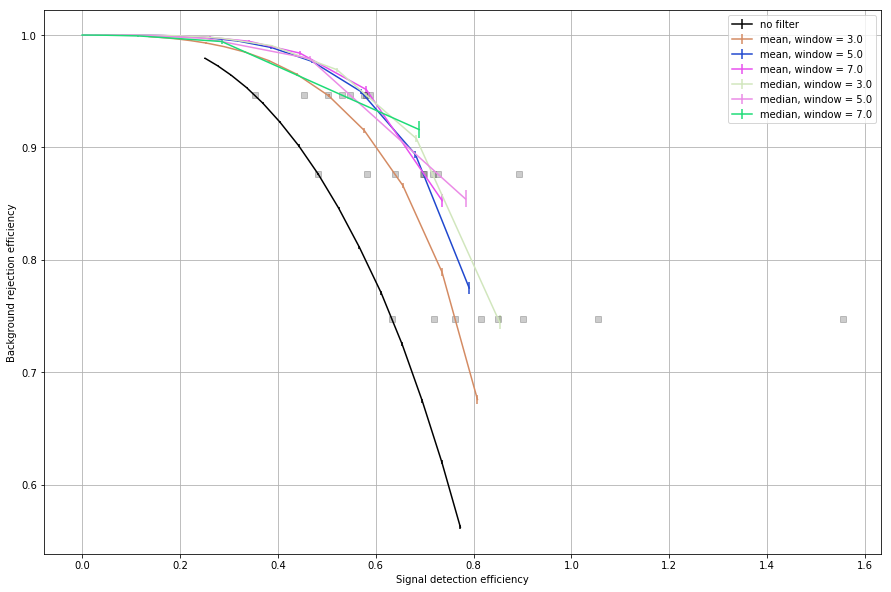

In [18]:
np.random.seed(5)
thr_points = [0.5,1,1.5]
new_thr_values = []
objects = roc_params_build(mean_sg,mean_bg,filters)
base_background_values = objects[filters[0]][1][1](thr_points)
base_signal_values = []
fig,ax = plt.subplots(1,1, figsize=(15,10))
flag = 0
for i,f in list(enumerate(filters)):
    base_signal_values.append(objects[f][2][1](base_background_values))
    if (sum(df_filt[df_filt['w_size'] == 1.0]['ftype'] == filters[i]) != 0):
        color = 'black'
        label = 'no filter'
        flag+=1
        if flag<=1:
            ax.errorbar(mean_sg[:,i],
                        mean_bg[:,i],
                        2*std_bg[:,i],
                        linestyle = '-',
                        label = label,
                        color = color) 
            
    else:
        color = '#%06X' % np.random.randint(0, 0xFFFFFF)
        label = f
        ax.errorbar(mean_sg[:,i],
                    mean_bg[:,i],
                    2*std_bg[:,i],
                    linestyle = '-',
                    label = label,
                    color = color) 
base_signal_values = np.array(base_signal_values).ravel()   
base_background_values = np.tile(base_background_values,len(filters))
ax.plot(base_signal_values,base_background_values,'sk',alpha = 0.2)
#plt.plot(impx_points,impy_points,'ko',alpha = 0.4)   
#plt.plot(impx_points,impy_points,'ko',alpha = 0.4)

#thr = df_filt[df_filt['ftype']=='mean, window = 1.0']['sg_eff_1.5'].mean()
#plt.plot(thr*np.ones((70,)),mean_bg[:,0],'--b', label = 'threshold = 1.5 sigma')
#thr = df_filt[df_filt['ftype']=='mean, window = 1.0']['sg_eff_0.5'].mean()
#plt.plot(thr*np.ones((70,)),mean_bg[:,0],'--r', label = 'threshold = 0.5 sigma')
#thr = df_filt[df_filt['ftype']=='mean, window = 1.0']['sg_eff_1.0'].mean()
#plt.plot(thr*np.ones((70,)),mean_bg[:,0],'--g', label = 'threshold = 1.0 sigma')
    
plt.legend()
plt.grid()
plt.xlabel('Signal detection efficiency')
plt.ylabel('Background rejection efficiency')

## Construindo as curvas de energia

In [19]:
#df_filt
df_filt['Energy Estimated'] = bug_array_fix(df_filt,'Energy Estimated')
df_filt['Energy Error'] = df_filt['Energy']-df_filt['Energy Estimated'] 
filters = df_filt['ftype'].unique()
mean_energy = np.zeros((df_filt['Energy Error'].iloc[0].shape[0],
                        filters.shape[0]))
std_energy = np.zeros_like(mean_energy)
for i,f in list(enumerate(filters)):
    aux = df_filt[df_filt['ftype'] == f]
    energy = np.array(aux['Energy Error'].tolist())
    if(len(roc_x.shape) > 2):
        energy = roc_x[:,:,0]
    mean_energy[:,i] = energy.mean(axis=0)
    std_energy[:,i] = energy.std(axis = 0)

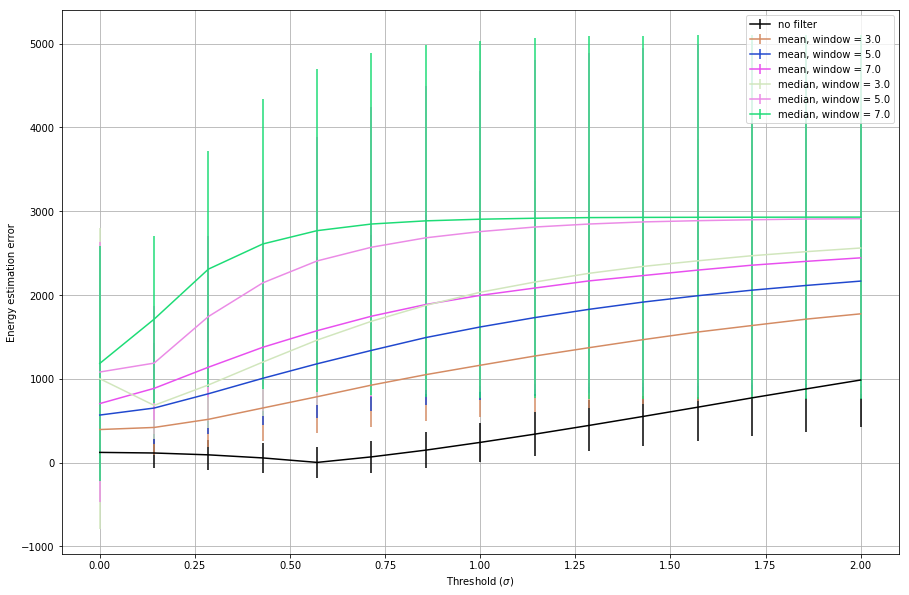

In [20]:
np.random.seed(5)
bound_sup = 2
bound_inf = 0
basis = np.linspace(bound_inf, bound_sup, 15)
fig,ax = plt.subplots(1,1, figsize=(15,10))
flag = 0
for i,f in list(enumerate(filters)):
    #base_signal_values.append(objects[f][2][1](base_background_values))
    if (sum(df_filt[df_filt['w_size'] == 1.0]['ftype'] == filters[i]) != 0):
        color = 'black'
        label = 'no filter'
        flag+=1
        if flag<=1:
            ax.errorbar(basis,
                        abs(mean_energy[:,i]),
                        2*std_energy[:,i],
                        linestyle = '-',
                        label = label,
                        color = color) 
            
    else:
        color = '#%06X' % np.random.randint(0, 0xFFFFFF)
        label = f
        ax.errorbar(basis,
                    abs(mean_energy[:,i]),
                    2*std_energy[:,i],
                    linestyle = '-',
                    label = label,
                    color = color) 

#plt.plot(abs(mean_energy))
plt.xlabel(r'Threshold ($\sigma$)')
plt.ylabel('Energy estimation error')
plt.grid()
plt.legend()
#plt.xlim([0.14,4])